In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import os
import joblib
import pickle


In [58]:
df = pd.read_csv(r"C:\Users\bhara\Desktop\project on aiml\HOUSE_PRICE_PREDICTION\house_price_data.csv")
df.columns = df.columns.str.strip()     
df.drop('Latitude', axis=1, inplace=True)
df.drop('Longitude', axis=1, inplace=True)
print("\n✅ CSV Columns Found:", df.columns.tolist())
print("\nFeatures after one-hot encoding:")
df_encoded = pd.get_dummies(df.drop('Price', axis=1))
print(df_encoded.columns.tolist())
print("\nData Preview:\n", df.head())


✅ CSV Columns Found: ['Square Footage', 'Bedrooms', 'Bathrooms', 'Zip Code', 'City', 'Year Built', 'Garage Size', 'Nearby Amenities', 'Condition', 'Crime Rate', 'School District Rating', 'Price']

Features after one-hot encoding:
['Square Footage', 'Bedrooms', 'Bathrooms', 'Zip Code', 'Year Built', 'Garage Size', 'Crime Rate', 'School District Rating', 'City_Chicago', 'City_Dallas', 'City_Los Angeles', 'City_New York', 'City_San Francisco', 'Nearby Amenities_Hospital, Park', 'Nearby Amenities_Mall, School, Hospital', 'Nearby Amenities_Park, Grocery, Gym', 'Condition_Below Average', 'Condition_Excellent', 'Condition_Good']

Data Preview:
    Square Footage  Bedrooms  Bathrooms  Zip Code         City  Year Built  \
0            3404         6          4     10001       Dallas        1958   
1            4414         4          1     60614     New York        2022   
2            3067         6          3     75201       Dallas        1975   
3            2813         3          1     94

In [42]:
# ========== 2. Create Output Folders ==========t
os.makedirs("output/plots", exist_ok=True)
os.makedirs("models", exist_ok=True)


In [43]:
# ========== 3. Encode Categorical Columns ==========
df = pd.get_dummies(df, drop_first=True)

In [44]:
# ========== 4. Define Features and Target ==========
target_column = 'Price'
if target_column not in df.columns:
    raise ValueError(f"❌ Target column '{target_column}' not found. Available columns: {df.columns.tolist()}")

X = df.drop(columns=[target_column])
y = df[target_column]

In [45]:
# ========== 5. Train/Test Split ==========
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Keep scaler for later use (saved to models/)

In [46]:
# ========== 6. Train Model ==========
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [47]:
# ========== 7. Evaluate ==========
print("\n📊 Evaluation Metrics:")
print("R² Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


📊 Evaluation Metrics:
R² Score: 0.9775484292638795
MAE: 45361.671401766354
RMSE: 56312.04077868586


In [48]:
# ========== 8. Save Model ==========
# Ensure 'models' folder exists
os.makedirs('models', exist_ok=True)
joblib.dump(model, r'C:\Users\bhara\Desktop\project on aiml\HOUSE_PRICE_PREDICTION\model\linear_model.pkl')
print('✅ Model saved to models/linear_model.pkl')
pickle.dump(scaler, open( r'C:\Users\bhara\Desktop\project on aiml\HOUSE_PRICE_PREDICTION\model\scaler.pkl', 'wb'))
print('✅ Scaler saved to models/scaler.pkl')
pickle.dump(scaler, open( r'C:\Users\bhara\Desktop\project on aiml\HOUSE_PRICE_PREDICTION\model\scaler.pkl', 'wb'))

✅ Model saved to models/linear_model.pkl
✅ Scaler saved to models/scaler.pkl


In [49]:
# ========== 9. Save Predictions ==========
# Recreate test feature DataFrame (scaled) so we can save alongside actual and predicted prices
pred_df = pd.DataFrame(X_test, columns=X.columns)
# y_test may be a Series or array; convert to a 1D numpy array for alignment
pred_df['Actual Price'] = getattr(y_test, 'values', y_test)
pred_df['Predicted Price'] = y_pred
pred_df.to_csv("output/predictions.csv", index=False)
print("✅ Predictions saved to output/predictions.csv")

✅ Predictions saved to output/predictions.csv


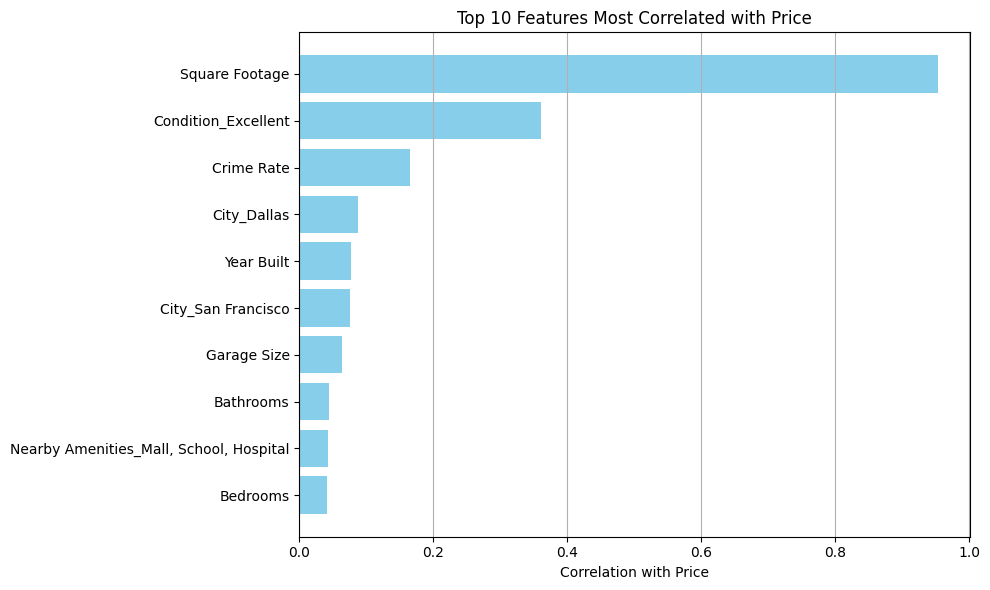

In [50]:
# ========== 10. Correlation Bar Chart ==========
corr = df.corr()
top_corr = corr[target_column].abs().sort_values(ascending=False)[1:11]

plt.figure(figsize=(10, 6))
plt.barh(top_corr.index[::-1], top_corr.values[::-1], color='skyblue')
plt.xlabel("Correlation with Price")
plt.title("Top 10 Features Most Correlated with Price")
plt.grid(True, axis='x')
plt.tight_layout()
plt.savefig("output/plots/correlation_bar_chart.png")
plt.show()

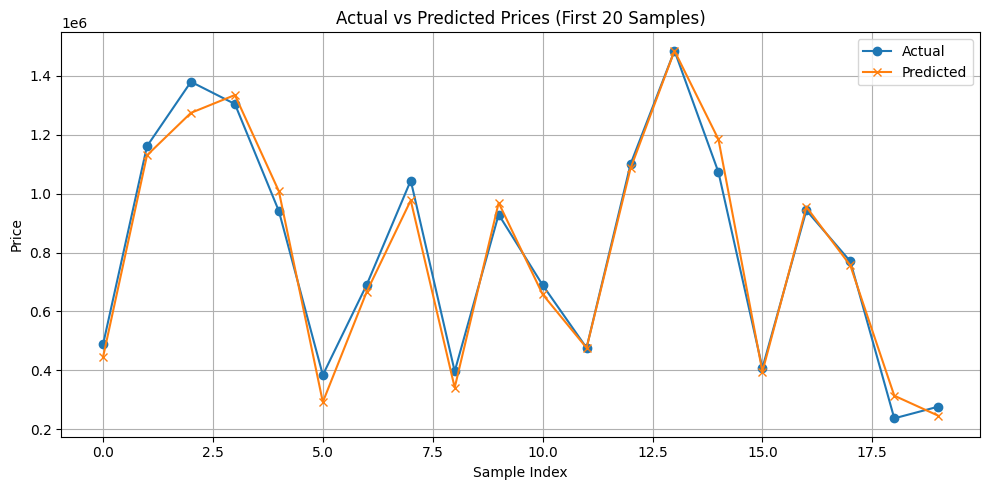

In [51]:
# ========== 11. Actual vs Predicted Line Plot ==========
plt.figure(figsize=(10, 5))
plt.plot(y_test.values[:20], label="Actual", marker='o')
plt.plot(y_pred[:20], label="Predicted", marker='x')
plt.title("Actual vs Predicted Prices (First 20 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("output/plots/actual_vs_predicted_line.png")
plt.show()

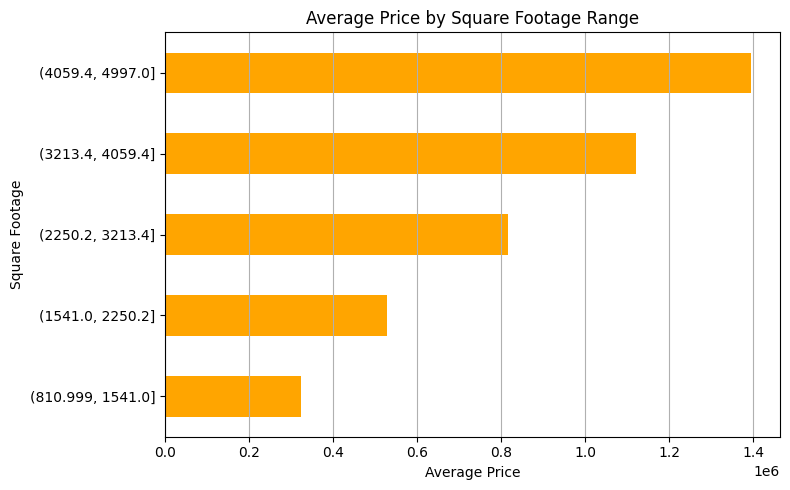

In [52]:
# ========== 12. Average Price by Top Feature ==========
top_features = corr[target_column].abs().sort_values(ascending=False).index[1:4]

for feature in top_features:
    if df[feature].nunique() >= 5:
        bins = pd.qcut(df[feature], q=5, duplicates='drop')
        grouped = df.groupby(bins, observed=False)[target_column].mean()

        plt.figure(figsize=(8, 5))
        grouped.plot(kind='barh', color='orange')
        plt.xlabel("Average Price")
        plt.title(f"Average Price by {feature} Range")
        plt.grid(True, axis='x')
        plt.tight_layout()
        plt.savefig(f"output/plots/bar_avg_price_by_{feature}.png")
        plt.show()
        break  # ✅ Only plot the FIRST valid feature


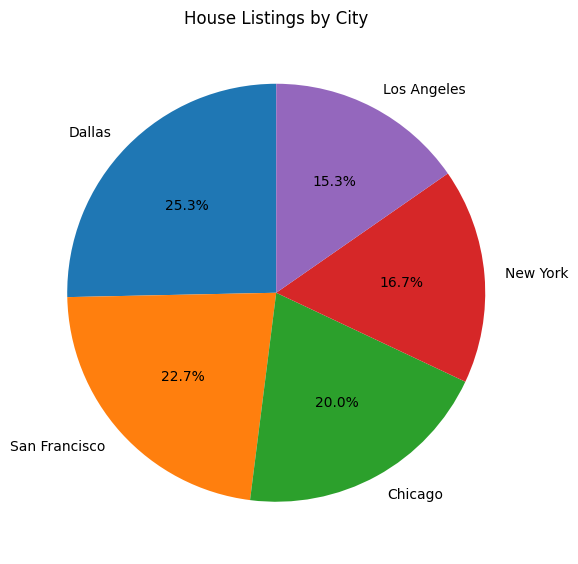

In [53]:
# ========== 13. Pie Chart: Distribution by City ==========
try:
    original_df = pd.read_csv(r"C:\Users\bhara\Desktop\project on aiml\HOUSE_PRICE_PREDICTION\house_price_data.csv")
    city_counts = original_df['City'].value_counts()

    plt.figure(figsize=(6, 6))
    plt.pie(city_counts, labels=city_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title("House Listings by City")
    plt.tight_layout()
    plt.savefig("output/plots/pie_city_distribution.png")
    plt.show()
except Exception as e:
    print(f"⚠️ Could not generate pie chart for City: {e}")

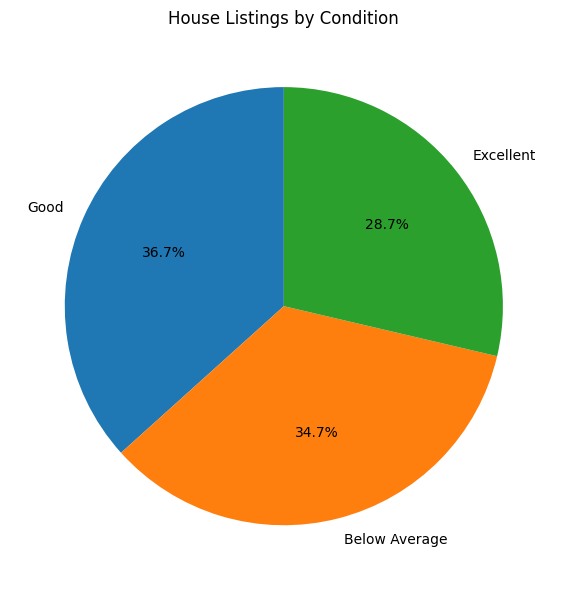

In [54]:
# ========== 14. Pie Chart: House Condition ==========
try:
    condition_counts = original_df['Condition'].value_counts()

    plt.figure(figsize=(6, 6))
    plt.pie(condition_counts, labels=condition_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title("House Listings by Condition")
    plt.tight_layout()
    plt.savefig("output/plots/pie_condition_distribution.png")
    plt.show()
except Exception as e:
    print(f"⚠️ Could not generate pie chart for Condition: {e}")

In [55]:
# load random classifier model
loaded_model = joblib.load(r'C:\Users\bhara\Desktop\project on aiml\HOUSE_PRICE_PREDICTION\model\linear_model.pkl')

# load scaler model
loaded_scaler = joblib.load(r'C:\Users\bhara\Desktop\project on aiml\HOUSE_PRICE_PREDICTION\model\scaler.pkl')

In [ ]:
def predict_price(square_footage, num_bedrooms, num_bathrooms, zip_code, year_built, garage_size, 
               city, nearby_amenities, condition, crime_rate, school_rating):
    """
    Predict house price based on given features
    
    Parameters:
    -----------
    square_footage: int/float - Total square footage of the house
    num_bedrooms: int - Number of bedrooms
    num_bathrooms: int/float - Number of bathrooms
    zip_code: int - ZIP code of the location
    year_built: int - Year the house was built
    garage_size: int - Size of the garage
    city: str - City ('Dallas', 'Houston', or 'San Antonio')
    nearby_amenities: str/list - Nearby amenities ('Park', 'Grocery', 'Gym', etc.)
    condition: str - Condition of the house ('Excellent', 'Good', or 'Fair')
    crime_rate: float - Crime rate in the area
    school_rating: float - School district rating
    """
    # Create binary variables for categorical features
    # City encoding
    city_dallas = 1 if city == 'Dallas' else 0
    city_houston = 1 if city == 'Houston' else 0
    city_san_antonio = 1 if city == 'San Antonio' else 0
    
    # Amenities encoding
    if isinstance(nearby_amenities, str):
        nearby_amenities = [x.strip() for x in nearby_amenities.split(',')]
    amenities_park = 1 if 'Park' in nearby_amenities else 0
    amenities_grocery = 1 if 'Grocery' in nearby_amenities else 0
    amenities_gym = 1 if 'Gym' in nearby_amenities else 0
    
    # Condition encoding
    condition_excellent = 1 if condition == 'Excellent' else 0
    condition_good = 1 if condition == 'Good' else 0
    condition_fair = 1 if condition == 'Fair' else 0
    
    # Create input data array with all features in correct order
    input_data = np.array([[
        square_footage,
        num_bedrooms,
        num_bathrooms,
        zip_code,
        year_built,
        garage_size,
        crime_rate,
        school_rating,
        city_dallas,
        city_houston,
        city_san_antonio,
        amenities_park,
        amenities_grocery,
        amenities_gym,
        condition_excellent,
        condition_good
    ]])
    
    # Scale the input data
    input_data_scaled = loaded_scaler.transform(input_data)
    
    # Make prediction
    prediction = loaded_model.predict(input_data_scaled)
    
    return prediction[0]

# Example usage
predicted_price = predict_price(
    square_footage=2500,      # 2500 sq ft
    num_bedrooms=4,          # 4 bedrooms
    num_bathrooms=3,         # 3 bathrooms
    zip_code=75001,          # Dallas area zip code
    year_built=2015,        # built in 2015
    garage_size=2,          # 2 car garage
    city='Dallas',          # located in Dallas
    nearby_amenities='Park, Grocery',  # nearby amenities
    condition='Good',       # in good condition
    crime_rate=5.2,        # example crime rate
    school_rating=8.5      # example school rating
)

print(f"Predicted House Price: ${predicted_price:,.2f}")

# Let's try another example
predicted_price2 = predict_price(
    square_footage=1800,     # smaller house
    num_bedrooms=3,         # 3 bedrooms
    num_bathrooms=2,        # 2 bathrooms
    zip_code=77001,         # Houston area zip code
    year_built=2010,       # older house
    garage_size=1,         # 1 car garage
    city='Houston',        # located in Houston
    nearby_amenities=['Park', 'Gym'],  # nearby amenities (as list)
    condition='Excellent', # excellent condition
    crime_rate=6.1,       # example crime rate
    school_rating=7.8     # example school rating
)

print(f"\nAnother Example:")
print(f"Predicted House Price: ${predicted_price2:,.2f}")

C:\Users\bhara\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


ValueError: X has 11 features, but StandardScaler is expecting 16 features as input.